# Linear LLM-innovator evolution chain


In [15]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt


# local package
import sys
sys.path.append('KDE/')
import template


# local env
from dotenv import load_dotenv, find_dotenv
import os


env_name = '.env'
load_dotenv(find_dotenv(env_name))

NANOGPT_APIKEY = os.getenv("NANOGPT_APIKEY")


# past nanoGPT API call data
import json

with open('nanoGPT_models.json', 'r') as f:
    a = json.load(f)
    
model_names = [aa['id'] for aa in a['data']]

In [16]:
seed = 1234
rng_params = np.random.default_rng(seed)
rng_samps = np.random.default_rng(seed + 1)

num_samples = 2 ** 20
z = rng_samps.normal(size=(num_samples, 1))

x = template.generate_samples(rng_params, z)

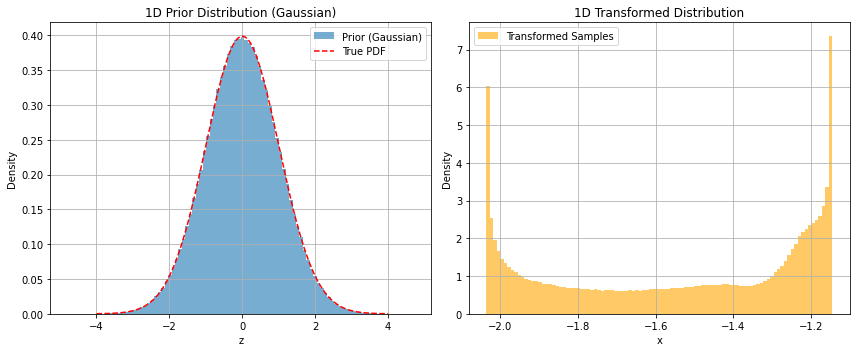

In [17]:
# Plot
plt.figure(figsize=(12, 5))

# Prior
plt.subplot(1, 2, 1)
plt.hist(z, bins=100, density=True, alpha=0.6, label="Prior (Gaussian)")
x_vals = np.linspace(-4, 4, 200)
plt.plot(x_vals, norm.pdf(x_vals), 'r--', label="True PDF")
plt.title("1D Prior Distribution (Gaussian)")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Transformed
plt.subplot(1, 2, 2)
plt.hist(x, bins=100, density=True, alpha=0.6, label="Transformed Samples", color="orange")
plt.title("1D Transformed Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
seed = 12349
rng_params = np.random.default_rng(seed)
rng_samps = np.random.default_rng(seed + 1)

num_samples = 2 ** 20
z = rng_samps.normal(size=(num_samples, 2))

x = template.generate_samples(rng_params, z)

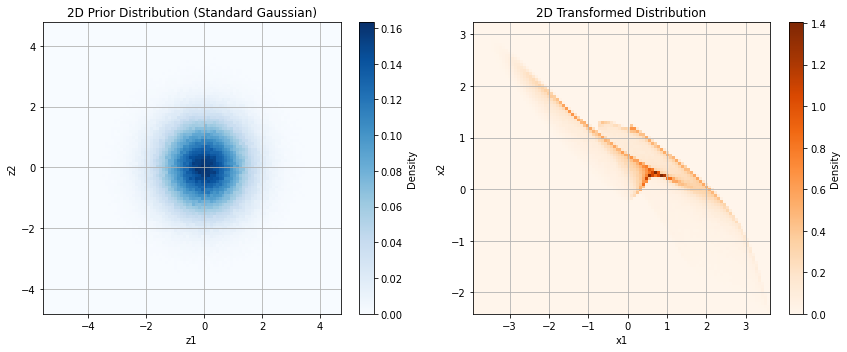

In [19]:
# Plot
plt.figure(figsize=(12, 5))

# Prior
plt.subplot(1, 2, 1)
plt.hist2d(z[:, 0], z[:, 1], bins=100, density=True, cmap='Blues')
plt.colorbar(label="Density")
plt.title("2D Prior Distribution (Standard Gaussian)")
plt.xlabel("z1")
plt.ylabel("z2")
#plt.axis("equal")
plt.grid(True)

# Transformed
plt.subplot(1, 2, 2)
plt.hist2d(x[:, 0], x[:, 1], bins=100, density=True, cmap='Oranges')
plt.colorbar(label="Density")
plt.title("2D Transformed Distribution")
plt.xlabel("x1")
plt.ylabel("x2")
#plt.axis("equal")
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
import src
import run_challenge_instance


system_prompt = run_challenge_instance.build_system_prompt(
    template.algorithm_prompt, template.feedback_prompt, template.first_algorithm)
print(system_prompt)

EvaluateAlgorithm, ConstructFeedback = src.utils.import_model_specific_symbols('KDE/template.py', ['EvaluateAlgorithm', 'ConstructFeedback'])


Code up an algorithm in Python 3 with the following goals and specifications: 
Write a function that takes in training data points of shape (num_pts, dims), as well as test data (num_test, dims), and spits out a scalar which is the estimated log likelihood of the test data.
You are implementing kernel density estimation using some form of bandwidth selection heuristic for your base kernel of choice.
Use only NumPy and SciPy and implement the rest from scratch.

I will run your algorithm on a set of problem instances and report back to you: 
Target score to maximize is your test likelihoods on a fixed set of problem instances (different datasets, here we test on 64 instances), we provide both per instance likelihoods and a single average over instances. In addition, you will get:
- Train data likelihoods (per instance and averaged)
- Time to run evaluation for all instances (we want this to be as low as possible, but prioritize the target score)
- Code complexity score (length of the P

In [10]:
model_name = "chatgpt-4o-latest"#"auto-model-basic"#"deepseek-r1-nano"#

api = src.llm.OpenAIAPI(provider="nanogpt")
api.set_api_key(NANOGPT_APIKEY)

temperature = 1.0
model = src.llm.BaseLLM(model_name, temperature)
model.set_api(api)
model.set_system_prompt(system_prompt)

In [ ]:
print_logger = src.logger.setup_logger(logger_name='linear_evolution', logger_filename=None)

In [11]:
# initial seed algorithm
algo_id = 1
with open(f'KDE/algo{algo_id}.py', 'w') as f:
    f.write(template.first_algorithm)
    

try:
    eval_results = EvaluateAlgorithm(123, f'KDE/algo{algo_id}.py')
    try:
        feedback_prompt = ConstructFeedback(eval_results)
    except Exception as err:
        feedback_prompt = 'ConstructFeedback error: ' + str(err)

except Exception as err:
    feedback_prompt = 'EvaluateAlgorithms error: ' + str(err)

feedback_prompt_list = [feedback_prompt]
print(algo_id)
receive_status, receive_message = model.send_prompt(feedback_prompt)
if receive_status:
    pycode = receive_message.split('<python>')[1].split('</python>')[0]
    reasontext = receive_message.split('<reasoning>')[1].split('</reasoning>')[0]

    pycode_list = [pycode]
    reasontext_list = [reasontext]
    
else:
    raise ValueError(receive_status)


# innovation loop
invalid_response_retry = False
for algo_id in range(2, 10):

    if invalid_response_retry is False:
        with open(f'KDE/algo{algo_id}.py', 'w') as f:
            f.write(pycode)
        
        try:
            eval_results = EvaluateAlgorithm(123, f'KDE/algo{algo_id}.py')
            try:
                feedback_prompt = ConstructFeedback(eval_results)
            except Exception as err:
                feedback_prompt = 'ConstructFeedback error: ' + str(err)

        except Exception as err:
            feedback_prompt = 'EvaluateAlgorithms error: ' + str(err)

    feedback_prompt_list.append(feedback_prompt)
    print(algo_id)
    receive_status, receive_message = model.send_prompt(feedback_prompt)
    if receive_status:
        try:
            pycode = receive_message.split('<python>')[1].split('</python>')[0]
            reasontext = receive_message.split('<reasoning>')[1].split('</reasoning>')[0]

            pycode_list.append(pycode)
            reasontext_list.append(reasontext)
            invalid_response_retry = False

        except Exception as err:
            feedback_prompt = 'Response formatting error: ' + str(err)
            pycode_list.append(None)
            reasontext_list.append(None)
            invalid_response_retry = True
            algo_id -= 1  # retry at same algorithm index
        
    else:
        raise ValueError(receive_status)



1
2
3
4
5
6
7
8
9


In [12]:
reasontext_list

['\nThe first algorithm achieves decent test log-likelihood, but the average is somewhat low compared to potential optimization. Although the implementation is already compact, the code length could be improved by simplifying and avoiding redundant operations. Specifically, I:\n\n1. Streamlined the logic in `log_prob_Gaussian` for computing Gaussian log-density by merging terms where possible.\n2. Updated the return value to explicitly compute the mean log-likelihood over the test set, which can provide a more standardized scalar result.\n3. Minimized unnecessary variables and optimized operation sequences.\n\nBy focusing on these changes, I expect to slightly improve code performance and complexity (lower byte count) while maintaining functionality and potentially optimizing runtime. I aim to tune bandwidth selection and kernel smoothing further in the next iterations to improve test likelihoods directly.\n',
 "\nI switched bandwidth selection from Silverman's rule to Scott's rule. Sc

In [14]:
feedback_prompt_list

["{'test_log_likelihood_average': 20.481855663675535, 'test_log_likelihood_per_instance': [29.238753963539402, 19.242634059039368, 19.8856145738893, 16.911362581555714, 18.215700627173675, 20.654120570483933, 23.135501428042424, 29.210667501807404, 20.098955355158978, 14.484063949917413, 22.366410868523126, 14.341281080170901, 17.510332832211592, 25.3434039970698, 16.89592307713794, 23.137170032269182, 13.77990553064243, 14.013621128286747, 17.20153857787365, 21.967130655630665, 17.88607173923633, 25.22406796837167, 28.97436654214386, 17.199055701729627, 22.238083327866054, 16.541206248420377, 14.137903431697694, 14.318363254322769, 21.34326749588243, 20.464569693419833, 22.931302376470434, 20.241370276481373, 14.44311419390284, 27.3103283369038, 18.19006128863468, 21.57890077482928, 19.819789014540966, 22.720191343129144, 18.900092347205216, 14.836402231854024, 18.905537747192987, 17.749351859624852, 22.753135806170064, 23.108166953888496, 22.500086083665348, 24.337028862641656, 29.18

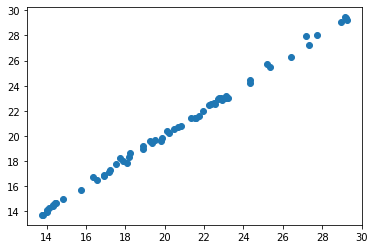

In [12]:
plt.scatter(eval_results['test_log_likelihood'], eval_results['train_log_likelihood'])

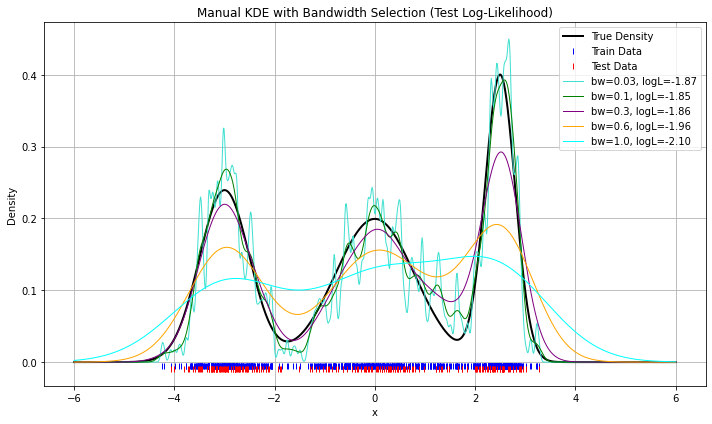

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set seed for reproducibility
np.random.seed(42)

# Generate multimodal data from a GMM
def sample_gmm(n_samples=1000):
    means = [-3, 0, 2.5]
    stds = [0.5, 0.8, 0.3]
    weights = [0.3, 0.4, 0.3]
    components = np.random.choice(len(means), size=n_samples, p=weights)
    samples = np.random.normal(loc=np.array(means)[components],
                               scale=np.array(stds)[components])
    return samples

# True GMM density
def true_gmm_pdf(x):
    means = [-3, 0, 2.5]
    stds = [0.5, 0.8, 0.3]
    weights = [0.3, 0.4, 0.3]
    return sum(w * norm.pdf(x, m, s) for w, m, s in zip(weights, means, stds))

# Manual KDE
def kde_estimate(x_eval, data, bandwidth):
    n = len(data)
    kernels = np.exp(-0.5 * ((x_eval[:, None] - data[None, :]) / bandwidth)**2)
    return np.mean(kernels, axis=1) / (bandwidth * np.sqrt(2 * np.pi))

# Log-likelihood on test data
def log_likelihood_kde(test_data, train_data, bandwidth):
    n = len(train_data)
    densities = np.array([
        np.mean(norm.pdf(x, train_data, bandwidth))
        for x in test_data
    ])
    return np.mean(np.log(densities + 1e-12))  # add epsilon for stability

# Sample data and split into train/test
data = sample_gmm(1000)
np.random.shuffle(data)
split = int(0.8 * len(data))
train_data = data[:split]
test_data = data[split:]

# Evaluation grid
x_grid = np.linspace(-6, 6, 1000)

# Plot setup
plt.figure(figsize=(10, 6))

# Plot true density
plt.plot(x_grid, true_gmm_pdf(x_grid), color='k', lw=2, label='True Density')

# Plot train/test samples
plt.plot(train_data, np.full_like(train_data, -0.005), '|', color='blue', label='Train Data')
plt.plot(test_data, np.full_like(test_data, -0.01), '|', color='red', label='Test Data')

# Bandwidths to try
bandwidths = [0.03, 0.1, 0.3, 0.6, 1.0]
colors = ['turquoise', 'green', 'purple', 'orange', 'cyan']

# Plot KDEs and compute log-likelihood
for bw, color in zip(bandwidths, colors):
    kde_vals = kde_estimate(x_grid, train_data, bw)
    ll = log_likelihood_kde(test_data, train_data, bw)
    plt.plot(x_grid, kde_vals, color=color, lw=1, label=f'bw={bw}, logL={ll:.2f}', alpha=1)

# Finalize plot
plt.title("Manual KDE with Bandwidth Selection (Test Log-Likelihood)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
# Compute interquartile range (IQR) for Silverman's alternative version
q75, q25 = np.percentile(train_data, [75, 25])
iqr = q75 - q25

# Silverman's rule with IQR adjustment (as per some implementations)
silverman_iqr_bw = 0.9 * min(std_dev, iqr / 1.34) * n ** (-1 / 5)

# Find the best bandwidth from the grid search
best_bw_idx = np.argmax(log_likelihoods)
best_bw = bandwidths[best_bw_idx]
best_ll = log_likelihoods[best_bw_idx]

# Plotting
fig, ax2 = plt.subplots(figsize=(10, 6))

# Bottom plot: Log-likelihood vs bandwidth
ax2.plot(bandwidths, log_likelihoods, label='Test Log-Likelihood', zorder=-2)

# Add scatter points for Silverman's rules and best bw
ax2.scatter([silverman_bw], 
            [log_likelihood_kde(test_data, train_data, silverman_bw)],
            color='red', marker='*', s=150, label="Silverman's Rule (std dev)")

ax2.scatter([silverman_iqr_bw], 
            [log_likelihood_kde(test_data, train_data, silverman_iqr_bw)],
            color='orange', marker='*', s=150, label="Silverman's Rule (IQR)")

ax2.scatter([best_bw], [best_ll], color='green', marker='*', s=150, label='Best Bandwidth (Grid Search)')

ax2.set_title("Test Log-Likelihood vs Bandwidth")
ax2.set_xlabel("Bandwidth")
ax2.set_ylabel("Log-Likelihood")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

NameError: name 'std_dev' is not defined